https://en.wikipedia.org/wiki/Natural_evolution_strategy

https://en.wikipedia.org/wiki/CMA-ES

Реализовать и сравнить алгоритмы оптимизации CMA-ES и NES на симулированных данных.
Результаты экспериментов предоставить в jupyter notebook
В том числе рассмотреть случаи:
    Функция:
        1. выпуклая
        2. несколько локальных минимумов
    Размерность
        1. dim=2
        2. dim=10
        3. dim=100
Для случая dim=2 нарисовать графики и анимацию.


In [91]:
import math
import numpy as np
import scipy
import scipy.linalg
import matplotlib.pyplot as plt
import time
from IPython import display
%matplotlib inline

In [2]:
def convex_func(x):
    # multidimensional parabola
    axis = 1 if x.ndim > 1 else 0    
    return np.sum(np.square(x - 1000), axis=axis)


def non_convex_func(x):
    axis = 1 if x.ndim > 1 else 0    
    # this thing is pretty close definition of Rastrigin which 
    # I reinvented accidentially without even knowing about Rastrigin
    return np.sum(np.square(x + 100) - 10 * x * np.cos(x), axis=axis)  


In [85]:
def plot_func_and_population(f, populations):
    plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for p in populations:
        ax.cla()
        x = np.arange(np.min(p) - 100, np.max(p) + 100, 0.05).reshape(-1, 1)

        ax.plot(x, f(x))
        ax.scatter(p, f(p))
        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(0.1)

def plot_func_and_population_2d(f, populations):
    plt.ion()
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cmap = plt.get_cmap('PiYG')
    for p in populations:
        ax.cla()
        x, y = np.mgrid[slice(np.min(p[:, 0]) - 100, np.max(p[:, 0]) + 100, 1),
                     slice(np.min(p[:, 1]) - 100, np.max(p[:, 1]) + 100, 1)]
        z = f(np.array(np.stack([x,y], axis=1)))[:-1, :-1]
        ax.pcolormesh(x, y, z, cmap=cmap)
        ax.scatter(p[:, 0], p[:, 1])
        display.display(fig)
        display.clear_output(wait=True)
        plt.pause(0.5)



In [88]:
def cma_es(f, dim, l):
    """
    Implementation of CMA-ES
    
    params:
    dim = dimensionality
    l = lambda, population size

    """
    m: np.array = np.zeros(dim)
    C: np.array = np.eye(dim)
    sigma: float = 0.5
        
    pc: np.array = np.zeros(dim)
    ps: np.array = np.zeros(dim)
    
    mu: int = l // 2
    weights: float = np.log(mu + 0.5) - np.log(np.arange(1, mu+1))
    weights /= np.sum(weights)
    mueff: float = np.sum(weights)**2 / np.sum(weights**2)
    
    print(weights)
    
    c1: float = 2. / ((dim  + 1.3)**2 + mueff)
    cmu: float = min(2. * (mueff - 2. + 1. /  mueff) / ((dim + 2.)**2 + mueff, 1. - c1))
    cs: float = (mueff + 2.0) / (dim + mueff + 5.)
    cc: float  = (4. + mueff / dim) / (dim + 4. + 2. * mueff / dim)
    damps = 1. + 2. * max(0, np.sqrt((mueff - 1.) / (dim + 1.)) - 1.) + cs
    print(c1, cmu, cs, cc, damps)
    
    eigenval = 0
    B = np.eye(dim)
    D = np.ones(dim)
    invC = B * (D ** -1) * B.T
    chiN = np.sqrt(dim) * (1 - 1. / (4. * dim) + 1. / (21. * dim ** 2))
    
    history = []
    counteval = 0
    stopeval = 1000
    g = 0
    while counteval < stopeval:
        # eval
        x = np.array([ m + sigma * np.dot(B, D*np.random.randn(dim)) for i in range(l) ])
        fitness = f(x)
        counteval += l  # actually there is only one, because batch invocation is supported
        g += 1
        
        # topk and mean
        x_select = x[np.argsort(fitness)][:mu]
        m_old = m
        m = np.dot(weights, x_select)
        history.append(x_select)
        #print(m)
        
        # path
        ps = (1 - cs) * ps + np.sqrt(cs * (2.0 - cs) * mueff) * invC * (m - m_old) / sigma
        hsig = float((np.linalg.norm(ps) / np.sqrt(1.-(1.-cs) ** (2. * counteval / l)) < 
                      (1.4 + 2. / (dim + 1.))) * chiN)
        pc = (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (m - m_old) / sigma
        
        # cov matrix
        y = np.add(x_select, m) / sigma
        c1_up = c1 * (np.outer(pc, pc) + (1 - hsig) * cc * (2.-cc) * C)
        cmu_up = 0
        for i in range(mu):
            t = (x_select[i] - m) / sigma
            cmu_up += weights[i] * np.outer(t, t)
        cmu_up *= cmu
        
        C = (1.0 - c1 - cmu) * C + c1_up + cmu_up
        
        # sigma
        sigma = sigma * np.exp((np.linalg.norm(ps) / chiN - 1) * cs / damps)
        #print("Norm", np.linalg.norm(C))
        #print("Sigma", sigma)
        
        if counteval - eigenval > l / (c1 + cmu) / dim / 10.0:  # dont forget
            #print("Recalc eigendecomposition")
            eigeneval = counteval;
            C = np.triu(C) + np.triu(C, 1).T
            D, B = np.linalg.eigh(C)
            idx = np.argsort(D)
            D = D[idx]
            B = B[:,idx]
            D = np.sqrt(D)
            invC = B * np.diag(1./D) * B.T

        if fitness[0] < 0 or np.linalg.norm(m - m_old) <= 1e-3:
            print("Breaking the loop")
            break
        
#       print({"x": x,
#                 "f": fitness, 
#                 "top_x" :x_select, 
#                 "w": weights, 
#                 "dot": d, 
#                 "mean" :m - m_old, 
#                 "yyyyy": y,
#                 'c1_up': c1_up,
#                 'cmu_up': cmu_up,
#                 "C": C, 
#                 "invC" : invC.astype(np.float16)
#             })

    print("Iterations:", g)
    print("Mean:", m)


    if dim == 1:
        plot_func_and_population(f, history)
    elif dim == 2:
        plot_func_and_population_2d(f, history)
    


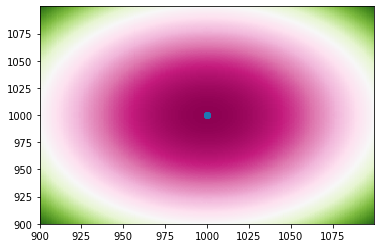

In [89]:
cma_es(convex_func, 2, 10)

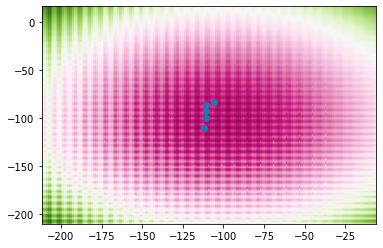

In [90]:
cma_es(non_convex_func, 2, 10)

In [79]:

def flat2triu(a, dim):
    res = np.zeros((dim, dim))
    index = 0
    for row in range(dim):
        res[row, row:] = a[index:index + dim - row]
        index += dim - row
    return res


def triu2flat(m):
    dim = m.shape[0]
    res = np.zeros(int(dim * (dim + 1) / 2))
    index = 0
    for row in range(dim):
        res[index:index + dim - row] = m[row, row:]
        index += dim - row
    return res


def nes(f, dim, l):
    """
    Implementation of NES
    Nearly direct implementation of http://is.tuebingen.mpg.de/fileadmin/user_upload/files/publications/CEC2008-Wierstra_[0].pdf
    which does not compute Fisher matrix directly
    
    Very poor performance on multimodal functions - needs lots of improvements i guess 
    (like population ranking, proper fitness baseline, different stop criterions)
    
    params:
    dim = dimensionality
    l = lambda, population size
    """
    m: np.array = np.random.randn(dim)
    A: np.array = np.eye(dim)
    sig = np.dot(A.T, A)

    beta: float = 0.4
    stopeval = 100
    g = 0
    history = []
    while g < stopeval:
        X = np.zeros((l, dim))
        FI = np.zeros((l, dim + (dim * (dim + 1) // 2) + 1))
        R = np.zeros((l))
        
        
        #print("M", m)
        #print("sig", sig)
        #print("A", A)
        invSig = scipy.linalg.inv(sig)
        invA = scipy.linalg.inv(A)
        diagInvA = np.diag(np.diag(invA))
        
        for k in range(l):
            x =  m + np.dot(A.T, np.random.randn(dim))
            fitness = f(x)
            R[k] = fitness
            X[k] = x
        
        #print(R)
        
        for k in range(l):
            x = X[k]
            gradMean = np.dot(invSig, (x - m))
        
            gradVar = np.dot(np.dot(invSig, np.outer(x - m, x - m)), invSig)/2. - invSig / 2.
            gradA = triu2flat(np.dot(A, (gradVar + gradVar.T)))
            
#             s = np.dot(invA.T, (x - m))
#             gradA = triu2flat(np.outer(s, np.dot(invA, s)) - diagInvA)
            
            FI[k, :dim] = gradMean
            FI[k, dim:-1] = gradA
            FI[k, -1] = 1

        history.append(X)

        delta = np.dot(scipy.linalg.pinv2(FI), R)
#         print("Delta", delta)
        m_old = m
        m = m - beta * delta[:dim]
        A = A - beta * flat2triu(delta[dim:-1], dim)
        sig = np.dot(A.T, A)
        
        g += 1
        
        if np.linalg.norm(m - m_old) <= 1e-3 or min(R) < -1e-3:
            print("breaking loop")

            break
            
    print("Iterations:", g)
    print("Mean:", m)

    if dim == 1:
        plot_func_and_population(f, history)
    elif dim == 2:
        plot_func_and_population_2d(f, history)



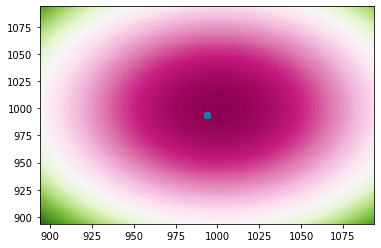

In [86]:
nes(convex_func, 2, 10)

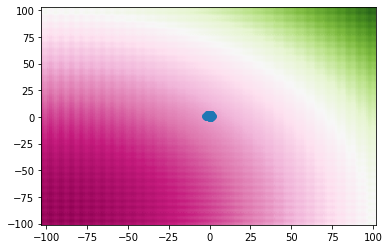

(208, 2, 210)


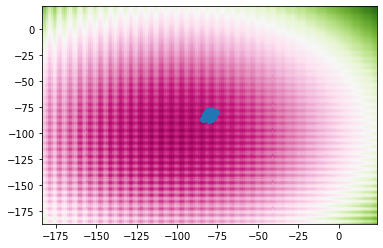

In [83]:
nes(non_convex_func, 2, 100)